In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gpflow.utilities import print_summary, set_trainable, to_default_float
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '4'

from sklearn.metrics import mean_squared_error, mean_absolute_error
from properscoring import crps_gaussian

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data
from useful_fun import plot_distribution, percentage_outof_CI

In [2]:
# load data

# whole dataset
data = get_birth_data()
x, y = separate_data(data, train_test=False)

# train/test split
df_train = pd.read_csv('../../data/train.csv')
x_train, y_train = separate_data(df_train)
df_test = pd.read_csv('../../data/test.csv')
x_test, y_test = separate_data(df_test)

# get date for x-axis in plots
def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs
pos, labels = get_xticks(data)

2022-08-24 17:15:26.566722: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-24 17:15:27.140128: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5


# Additive model:  two-latent functions

        y = f(x) + g(x) + e
        f = GP(0, RBF)
        g = GP(0, Periodic)

Noise variance is not trained.

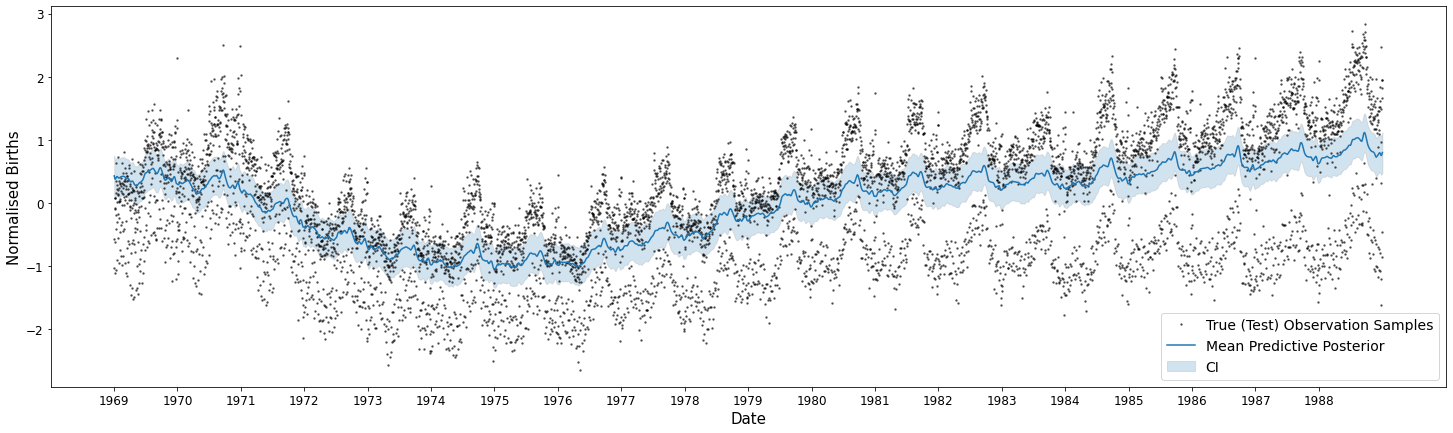

Fitted values MSE:  0.6091584529448275
Log-marginal likelihood:  -9159.317977588624
Percentage of points out of CI:  74.05886379192333


In [5]:
# build model & compute fitted values

kernel = gpflow.kernels.RBF() + gpflow.kernels.Periodic(gpflow.kernels.RBF())

model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
set_trainable(model.likelihood.variance , False)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

mean, var = model.predict_f(x)

plot_distribution(x, y, mean, var, pos, labels)

print('Fitted values MSE: ', mean_squared_error(y, mean))
print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())
print('Percentage of points out of CI: ',  percentage_outof_CI(y, mean, var))

print_summary(model, fmt='notebook')

Not a very good fit. The period parameter value doesn't really make sense. Should be yearly periodic.

Set period to mean average of days per year and don't train it.

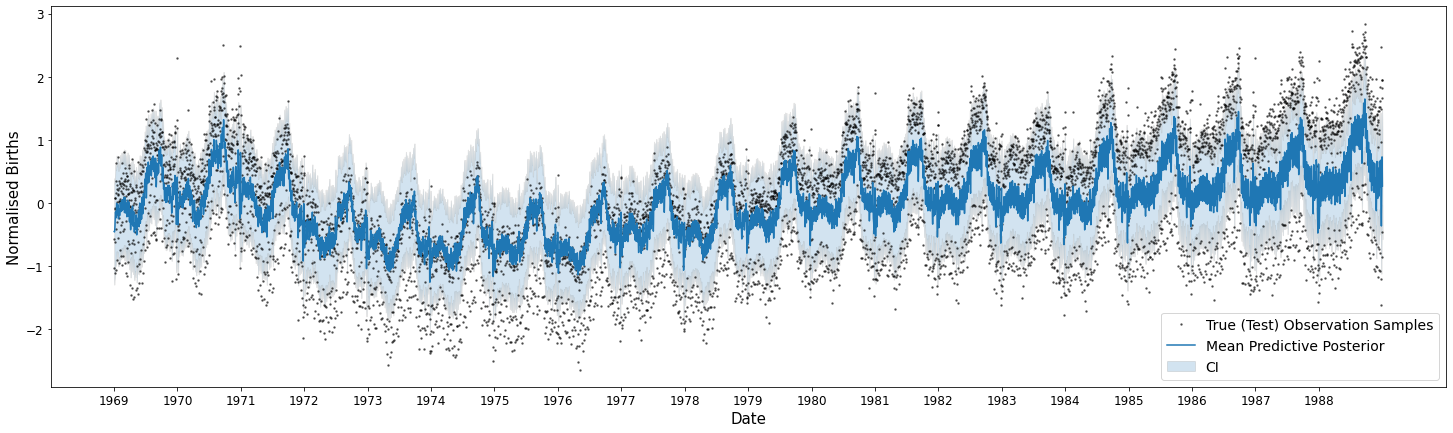

Fitted values MSE:  0.45556215463456534
Log-marginal likelihood:  -9674.272486034979
Percentage of points out of CI:  32.42984257357974


In [5]:
# re-build model & set period

kernel = gpflow.kernels.RBF() + gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25)

model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
set_trainable(model.likelihood.variance , False)
set_trainable(model.kernel.kernels[1].period , False)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

mean, var = model.predict_f(x)

plot_distribution(x, y, mean, var, pos, labels)

print('Fitted values MSE: ', mean_squared_error(y, mean))
print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())
print('Percentage of points out of CI: ',  percentage_outof_CI(y, mean, var))

print_summary(model, fmt='notebook')

Worse fit !!! The CI is also not good enough(?)

Add priors to penalised small length scales. 

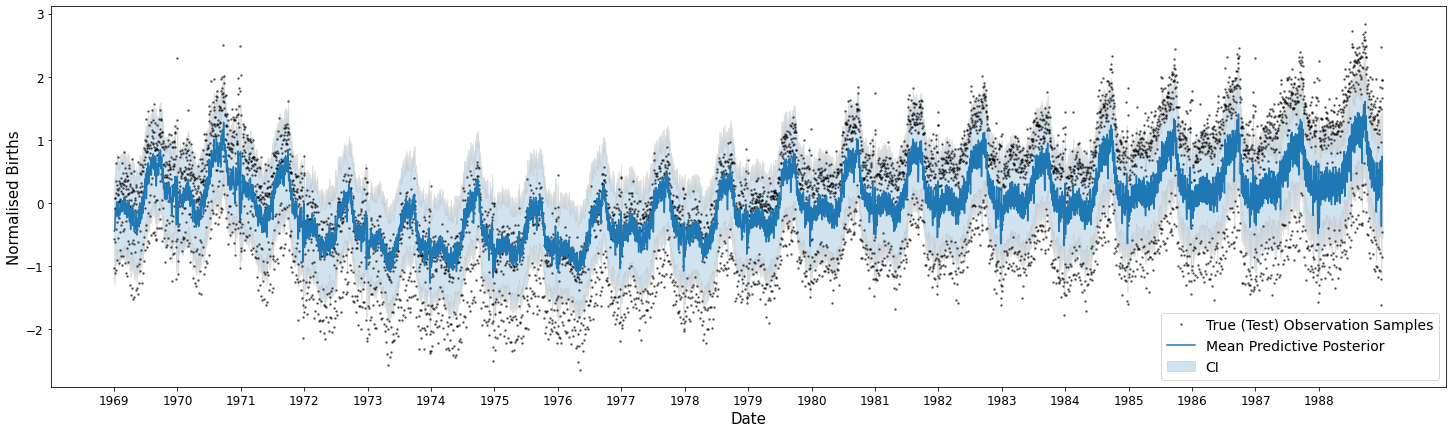

Fitted values MSE:  0.45407092511846764
Log-marginal likelihood:  -9675.879666018072
Percentage of points out of CI:  31.90965092402464


In [4]:
# add prior to hyperparameters

kernel = gpflow.kernels.RBF() + gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25)

model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
set_trainable(model.likelihood.variance , False)
set_trainable(model.kernel.kernels[1].period , False)

# adding priors
model.kernel.kernels[0].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
model.kernel.kernels[0].variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))
model.kernel.kernels[1].base_kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
model.kernel.kernels[1].base_kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

mean, var = model.predict_f(x)

plot_distribution(x, y, mean, var, pos, labels)

print('Fitted values MSE: ', mean_squared_error(y, mean))
print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())
print('Percentage of points out of CI: ',  percentage_outof_CI(y, mean, var))

print_summary(model, fmt='notebook')

No improvement. Maybe starting conditions will generate better fit.

Investigate how the hyperparameter starting point affects the fitting of the model.

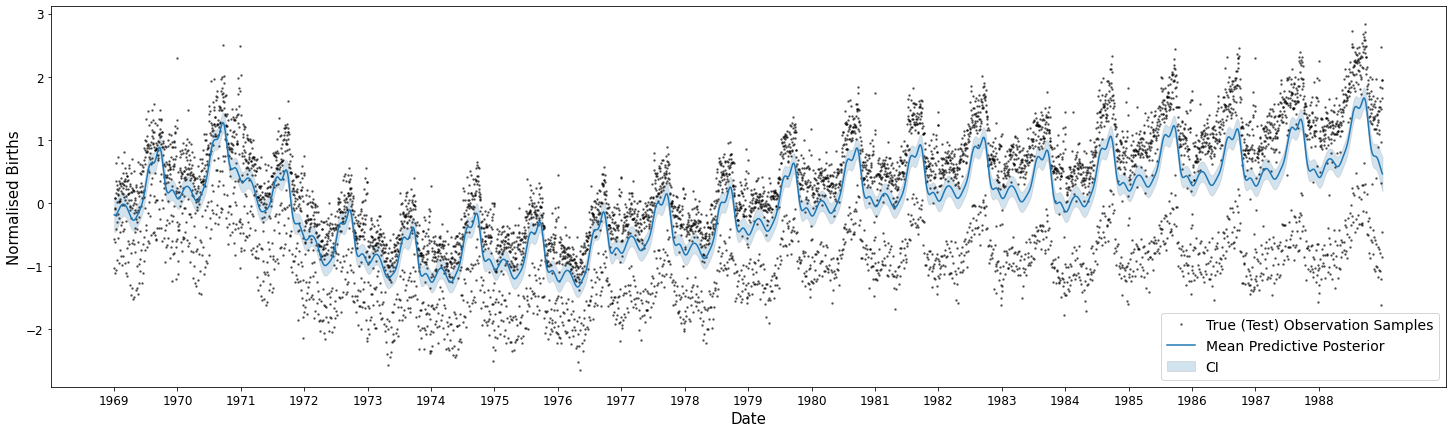

Fitted values MSE:  0.550096878345392
Log-marginal likelihood:  -8832.998966801333
Percentage of points out of CI:  91.56741957563312


In [6]:
# add prior to hyperparameters

kernel = gpflow.kernels.RBF(lengthscales=5) + gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25)

model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
set_trainable(model.likelihood.variance , False)
set_trainable(model.kernel.kernels[1].period , False)

# adding priors
model.kernel.kernels[0].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
model.kernel.kernels[0].variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))
model.kernel.kernels[1].base_kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
model.kernel.kernels[1].base_kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

mean, var = model.predict_f(x)

plot_distribution(x, y, mean, var, pos, labels)

print('Fitted values MSE: ', mean_squared_error(y, mean))
print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())
print('Percentage of points out of CI: ',  percentage_outof_CI(y, mean, var))

print_summary(model, fmt='notebook')

_______________________
_______________________

Since we have already investigated the effect of prior to be good in basic gp, we leave this additive GPR model and move to additive SVGP model.

Train and Test

In [4]:
def optimise_predict_model(model, epochs=50):
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(model.training_loss, model.trainable_variables)
    
    # fitted values
    mean_train, var_train = model.predict_y(x_train)
    print('Train')
    plot_distribution(x_train, y_train, mean_train, var_train, pos, labels, legend=False)

    # predict
    mean_test, var_test = model.predict_y(x_test)
    print('Test')
    plot_distribution(x_test, y_test, mean_test, var_test, pos, labels)

    print('train ELBO, MSE, MAE: ', mean_squared_error(y_train, mean_train), mean_absolute_error(y_train, mean_train))
    print('test ELBO, MSE, MAE: ', mean_squared_error(y_test, mean_test), mean_absolute_error(y_test, mean_test))
    print('percentage out of CI (train, test): ', percentage_outof_CI(y_train, mean_train, var_train), percentage_outof_CI(y_test, mean_test, var_test))
    print('Avg. CRPS (train, test): ', np.mean(crps_gaussian(y_train, mean_train, np.sqrt(var_train))), np.mean(crps_gaussian(y_test, mean_test, np.sqrt(var_test))))

    print_summary(model, fmt='notebook')

Train


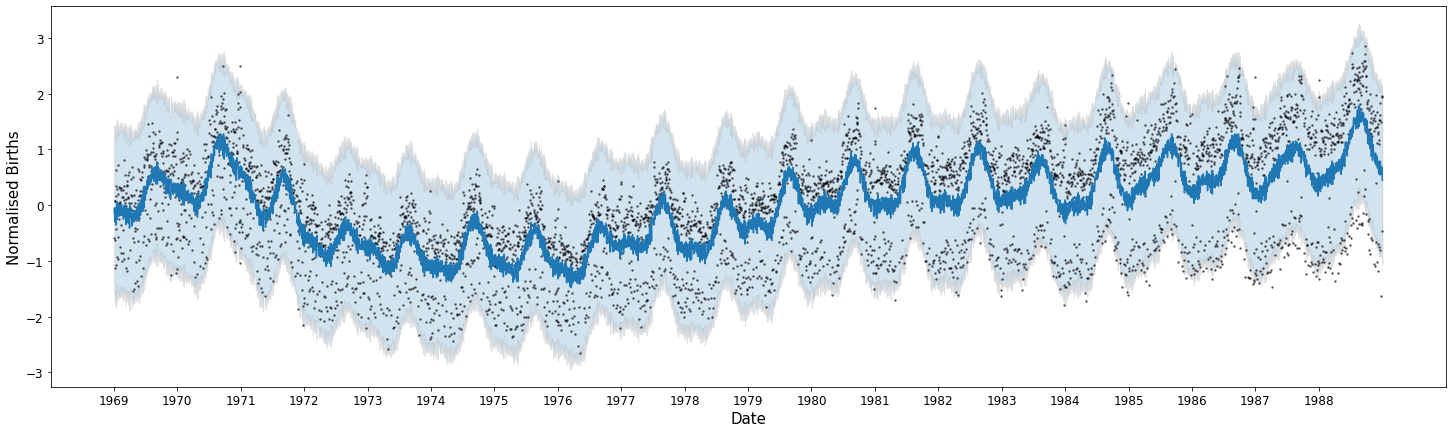

Test


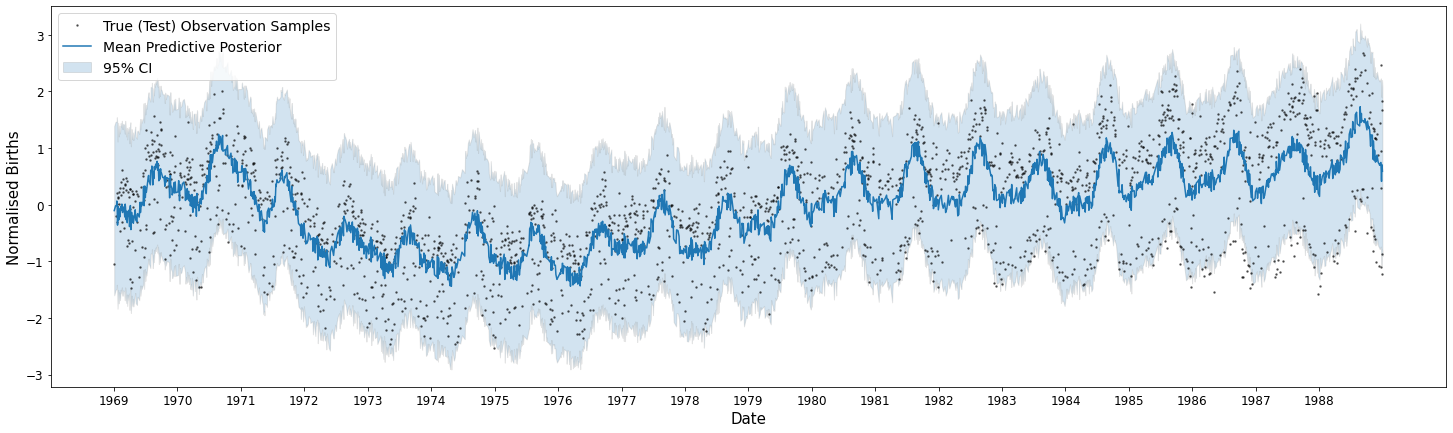

train ELBO, MSE, MAE:  0.533586090435419 0.6149900662116267
test ELBO, MSE, MAE:  0.567604289480822 0.6313351887744793
percentage out of CI (train, test):  2.6598865636612556 3.1934306569343067
Avg. CRPS (train, test):  0.4188258692966241 0.43232949370975404


In [8]:
kernel = gpflow.kernels.RBF(lengthscales=77, variance=1) + gpflow.kernels.Periodic(gpflow.kernels.Matern32(), period=77)
model = gpflow.models.GPR(data=(x_train, y_train), kernel=kernel, mean_function=None)

optimise_predict_model(model)

Train


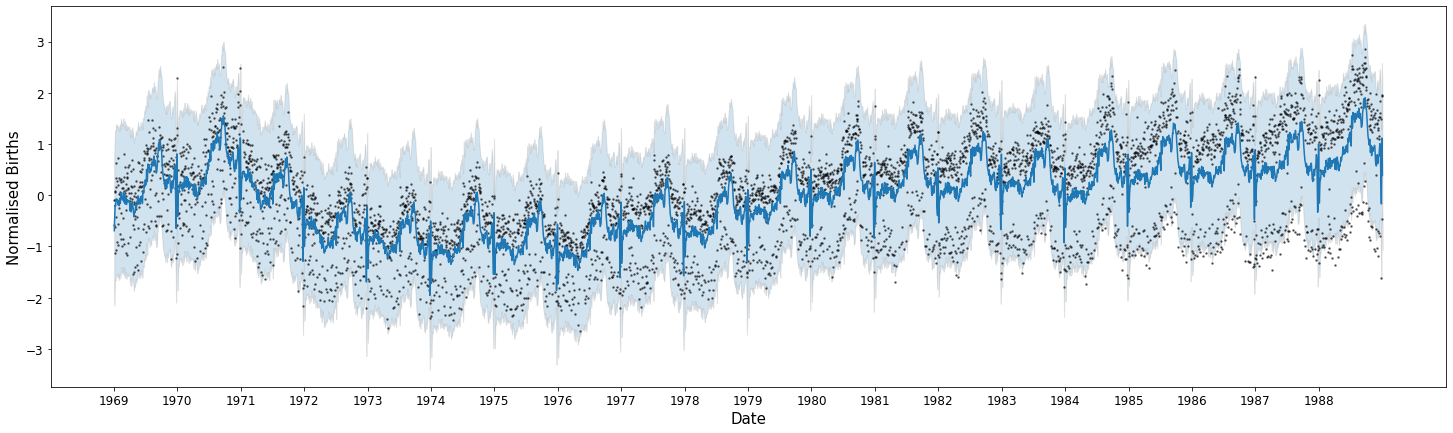

Test


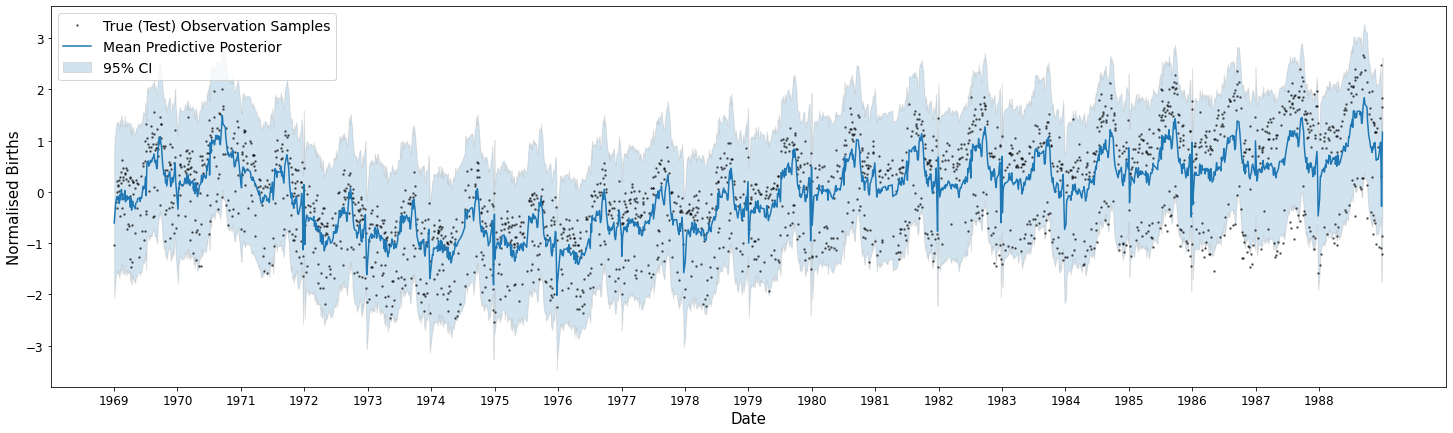

train ELBO, MSE, MAE:  0.5134429314704428 0.6043546134337627
test ELBO, MSE, MAE:  0.5592170129060796 0.6292227564437427
percentage out of CI (train, test):  3.3444161940152553 4.060218978102189
Avg. CRPS (train, test):  0.41006407385118404 0.4283517099983594


In [9]:
kernel = gpflow.kernels.RBF(lengthscales=77, variance=1) + gpflow.kernels.Periodic(gpflow.kernels.Matern32(), period=365)
model = gpflow.models.GPR(data=(x_train, y_train), kernel=kernel, mean_function=None)

optimise_predict_model(model)

Train


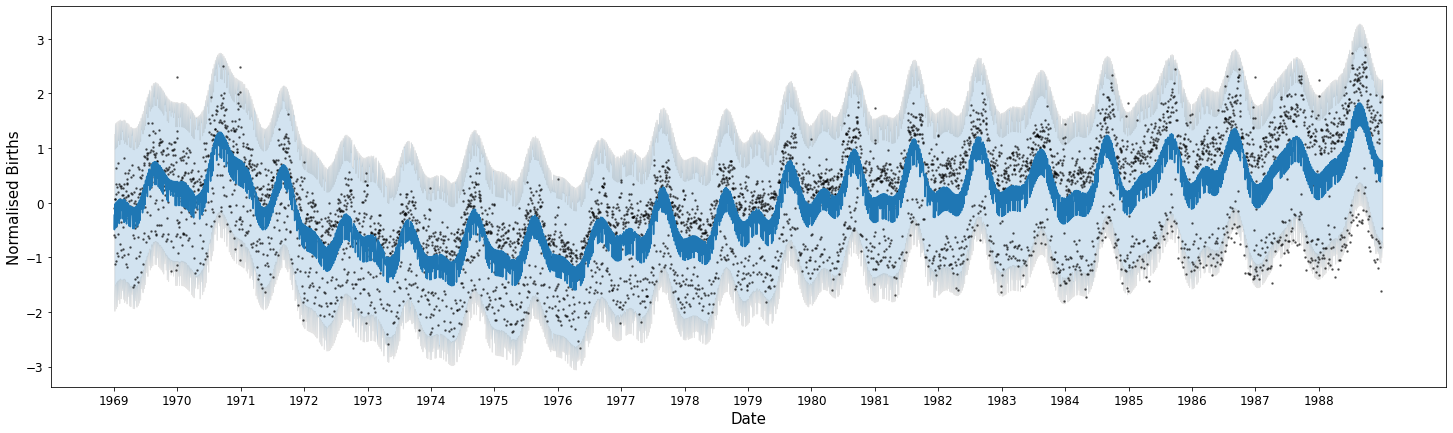

Test


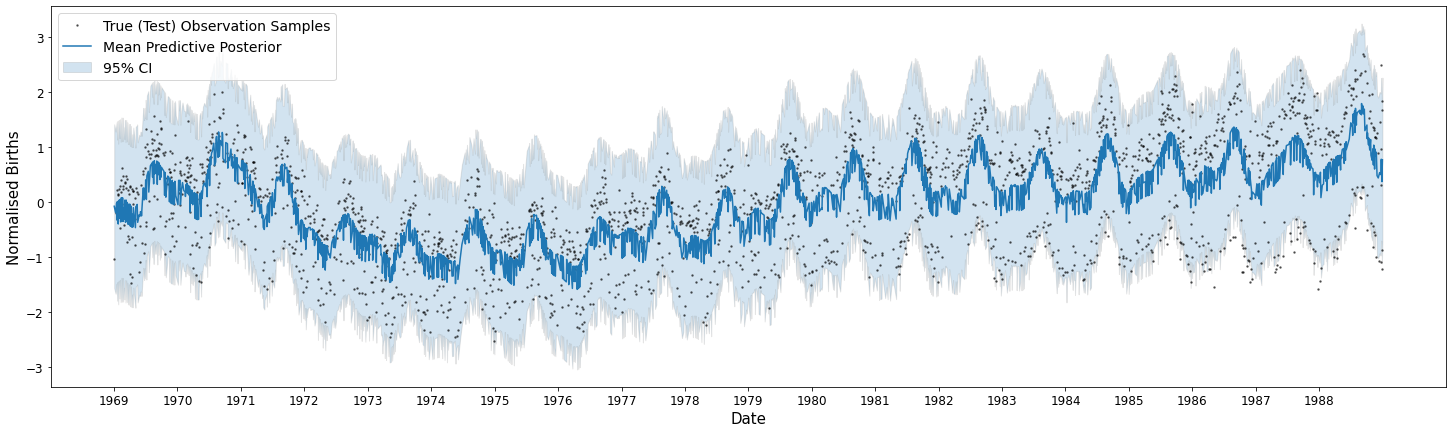

train ELBO, MSE, MAE:  0.5259631949162895 0.607291533018514
test ELBO, MSE, MAE:  0.5631969106424898 0.6271317455238621
percentage out of CI (train, test):  2.8554664580481126 3.7408759124087596
Avg. CRPS (train, test):  0.41595025690430054 0.43087561841860667


---------------------------------------
Train


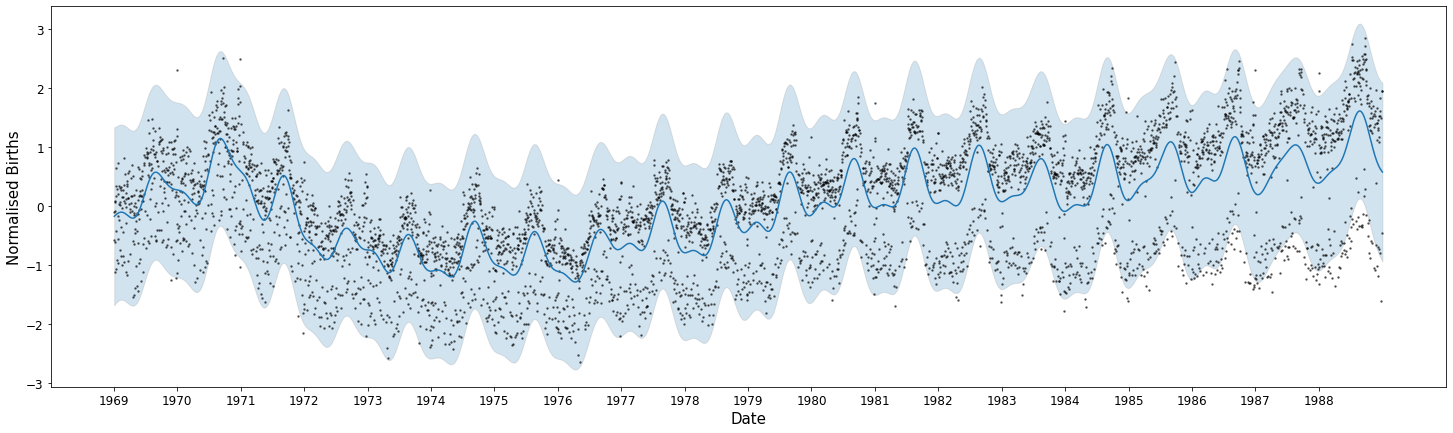

Test


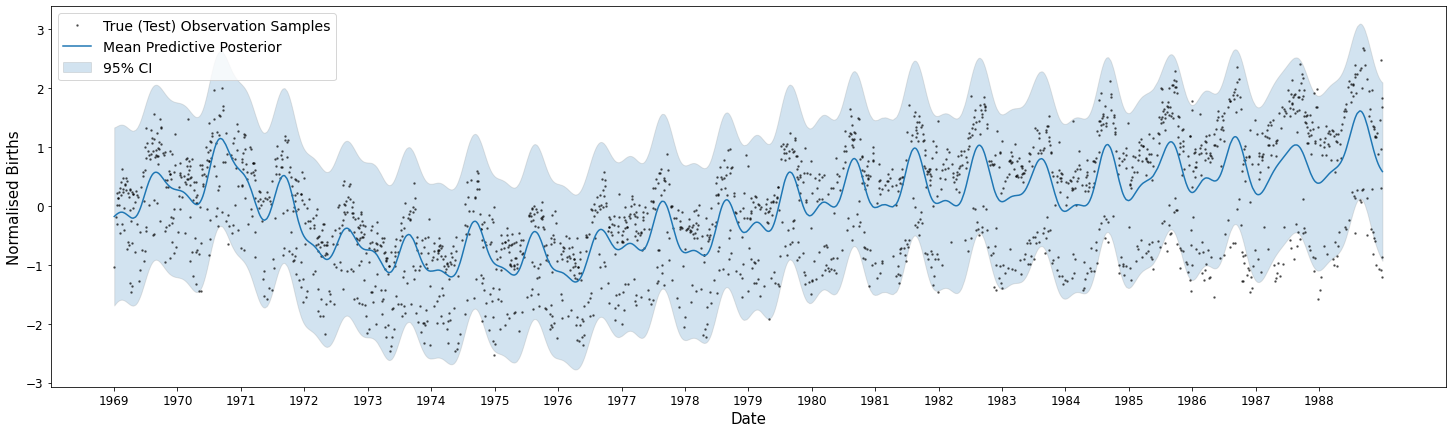

train ELBO, MSE, MAE:  0.5525255842386136 0.6258964156908425
test ELBO, MSE, MAE:  0.5864401209878912 0.6443899484636757
percentage out of CI (train, test):  3.207510267944455 3.64963503649635
Avg. CRPS (train, test):  0.42566876507284457 0.43922983502967994


---------------------------------------
Train


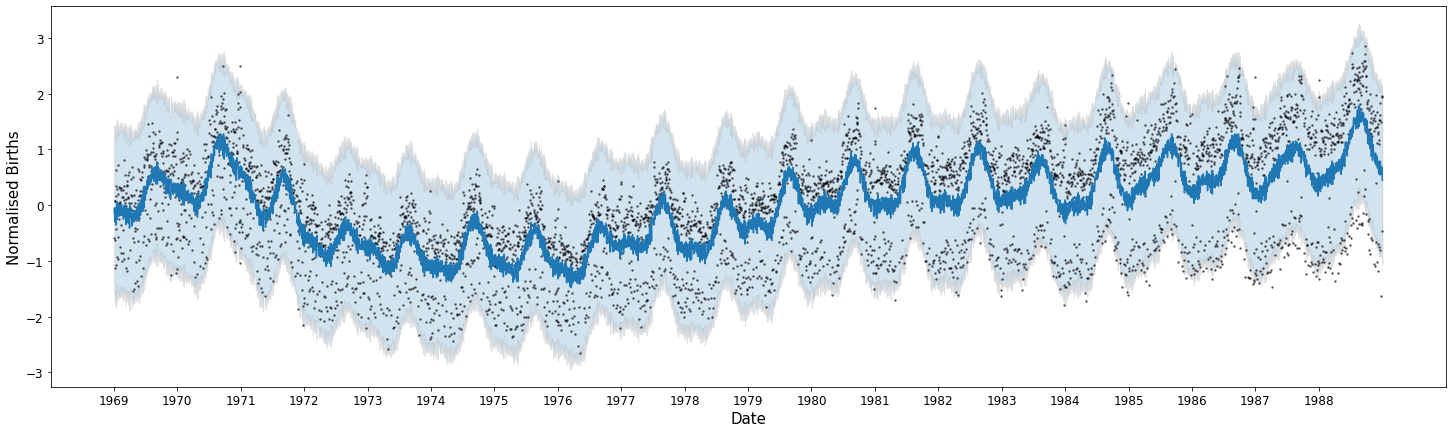

Test


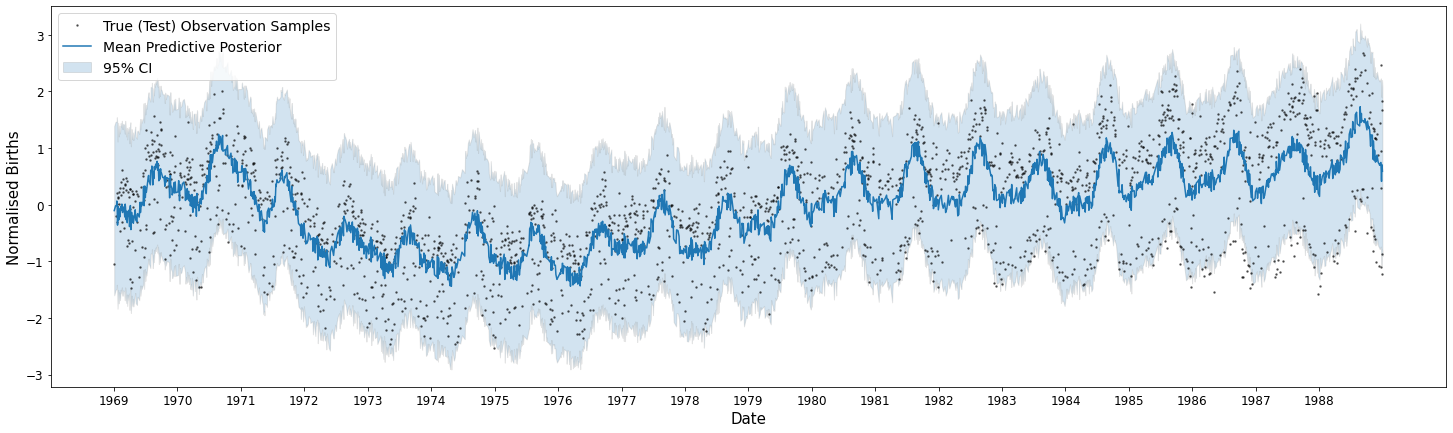

train ELBO, MSE, MAE:  0.533586090435419 0.6149900662116267
test ELBO, MSE, MAE:  0.567604289480822 0.6313351887744793
percentage out of CI (train, test):  2.6598865636612556 3.1934306569343067
Avg. CRPS (train, test):  0.4188258692966241 0.43232949370975404


---------------------------------------
Train


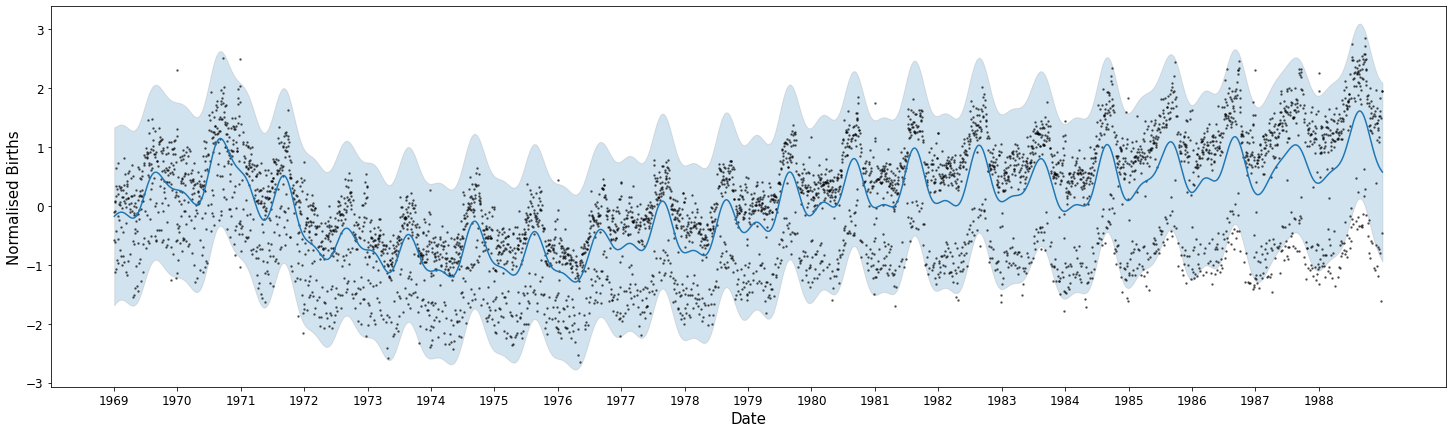

Test


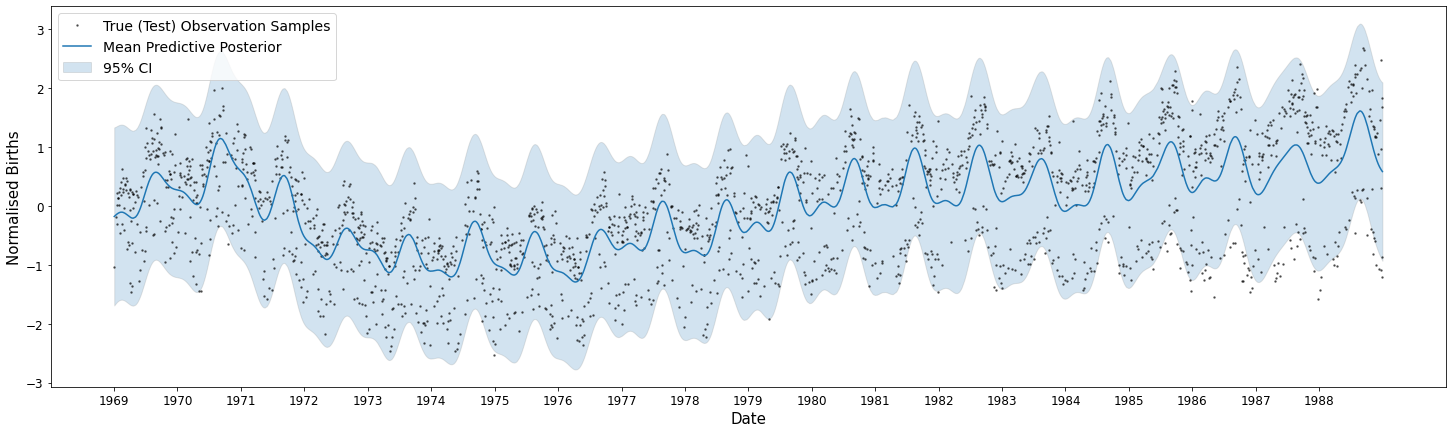

train ELBO, MSE, MAE:  0.5525257211075252 0.6258964404911813
test ELBO, MSE, MAE:  0.5864402477489953 0.6443899396361217
percentage out of CI (train, test):  3.207510267944455 3.64963503649635
Avg. CRPS (train, test):  0.4256686659756587 0.4392296428402102


---------------------------------------
Train


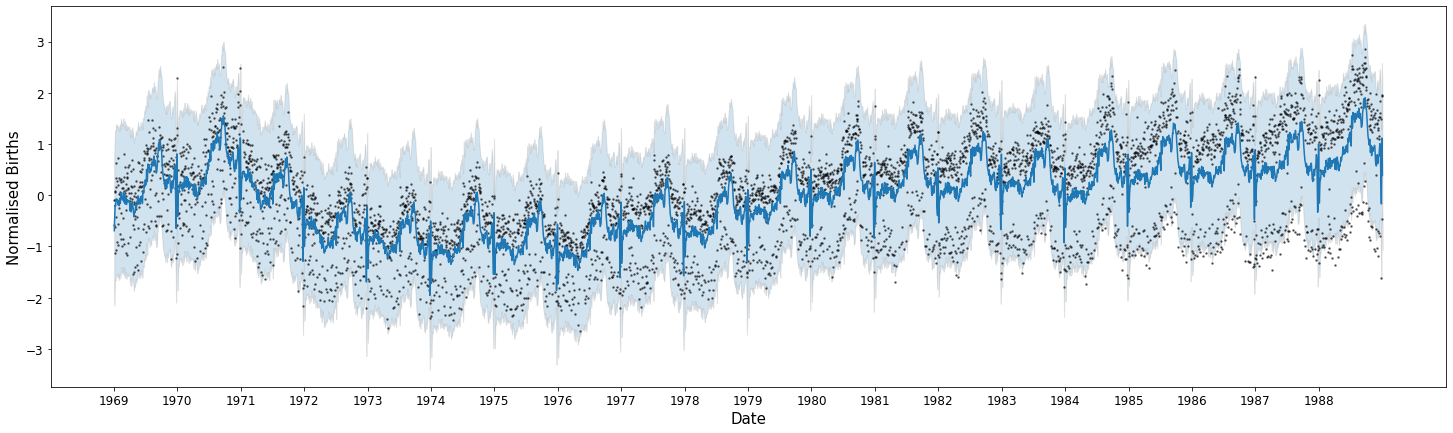

Test


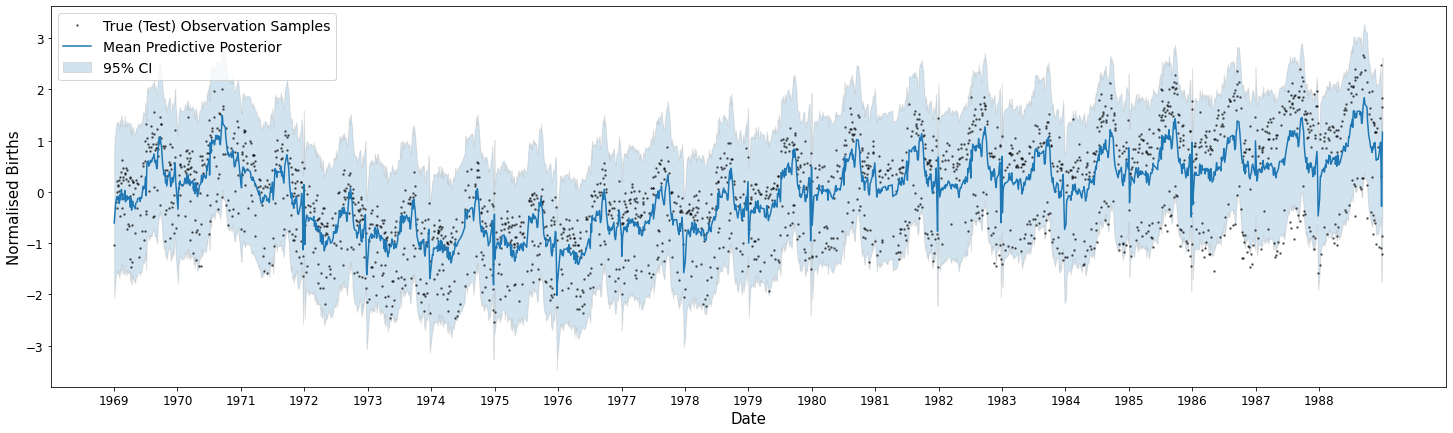

train ELBO, MSE, MAE:  0.5134429314704428 0.6043546134337627
test ELBO, MSE, MAE:  0.5592170129060796 0.6292227564437427
percentage out of CI (train, test):  3.3444161940152553 4.060218978102189
Avg. CRPS (train, test):  0.41006407385118404 0.4283517099983594


---------------------------------------


In [11]:
for p in [1, 30, 77, 100, 365]:
    kernel = gpflow.kernels.RBF(lengthscales=77, variance=1) + gpflow.kernels.Periodic(gpflow.kernels.Matern32(), period=p)
    model = gpflow.models.GPR(data=(x_train, y_train), kernel=kernel, mean_function=None)

    optimise_predict_model(model)
    print('---------------------------------------')

2022-08-24 17:20:45.873657: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-24 17:20:49.662354: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x1d237600


Train


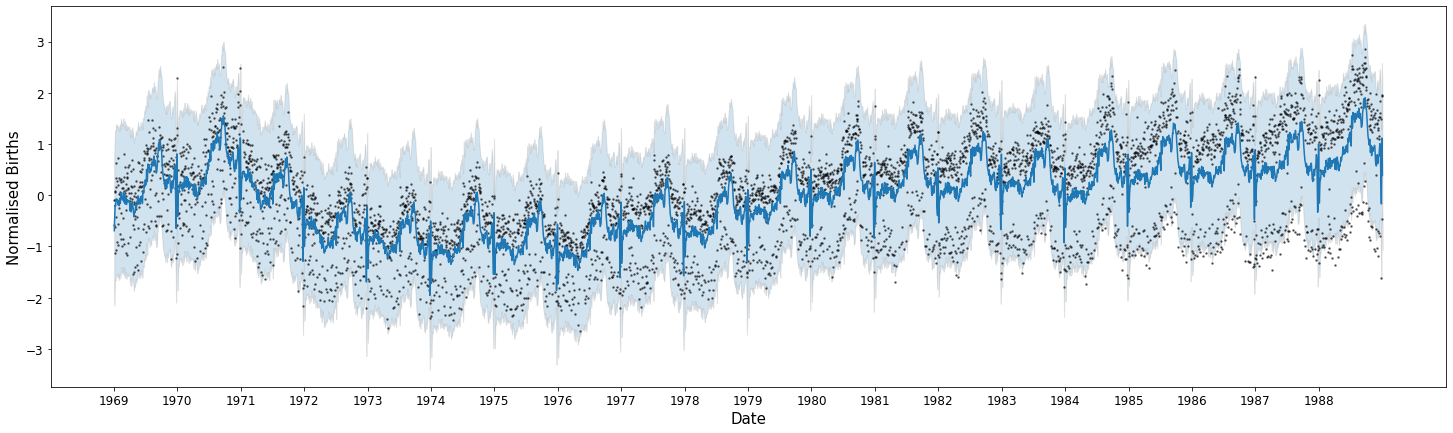

Test


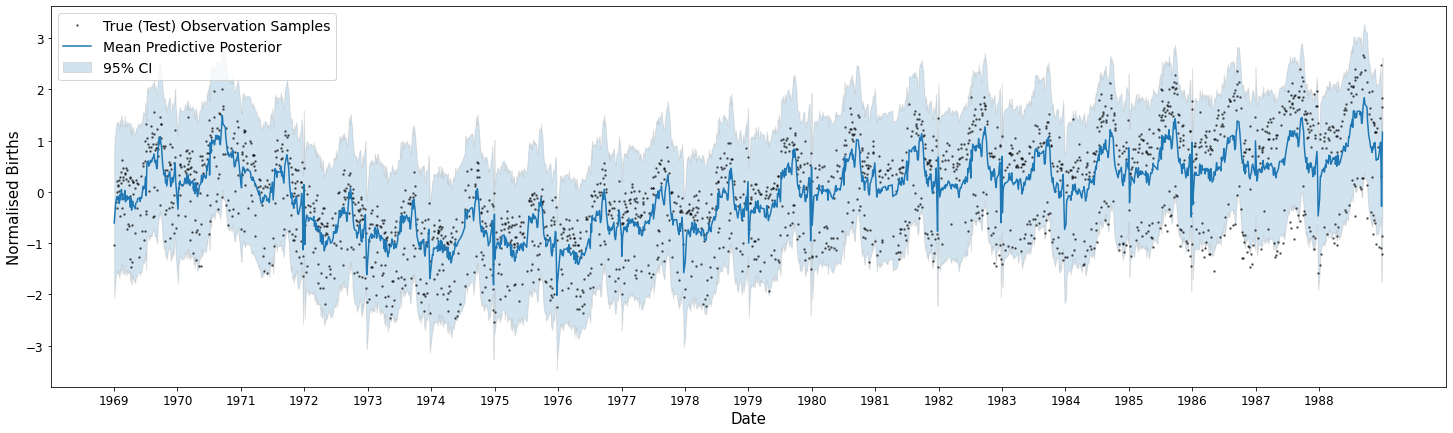

train ELBO, MSE, MAE:  0.5134429314704428 0.6043546134337627
test ELBO, MSE, MAE:  0.5592170129060796 0.6292227564437427
percentage out of CI (train, test):  3.3444161940152553 4.060218978102189
Avg. CRPS (train, test):  0.41006407385118404 0.4283517099983594


---------------------------------------
Train


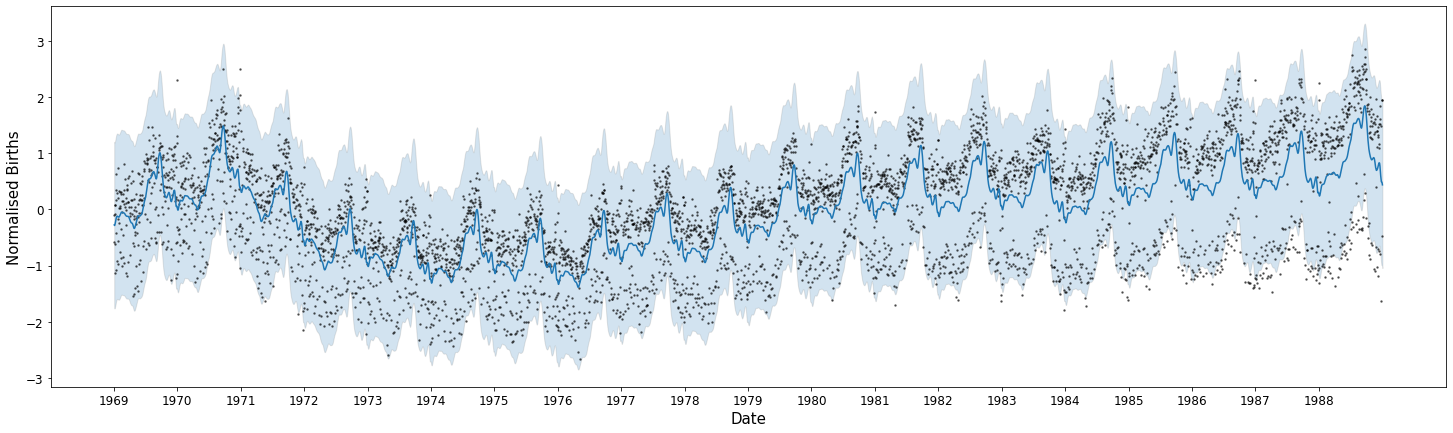

Test


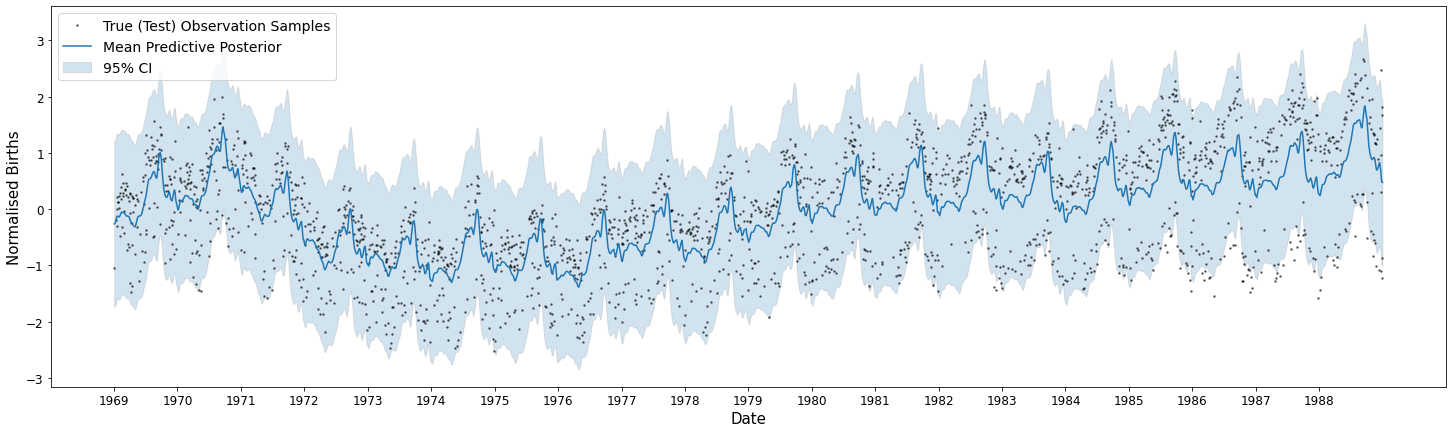

train ELBO, MSE, MAE:  0.5420515597348302 0.6212552345383976
test ELBO, MSE, MAE:  0.5669331286661883 0.6352589024140685
percentage out of CI (train, test):  3.4030901623313126 3.4671532846715327
Avg. CRPS (train, test):  0.4215180520243658 0.43175794142888657


---------------------------------------


In [5]:
for l1 in [77, 170]:
    kernel = gpflow.kernels.RBF(lengthscales=l1, variance=1) + gpflow.kernels.Periodic(gpflow.kernels.Matern32(), period=365)
    model = gpflow.models.GPR(data=(x_train, y_train), kernel=kernel, mean_function=None)

    optimise_predict_model(model)
    print('---------------------------------------')

Train


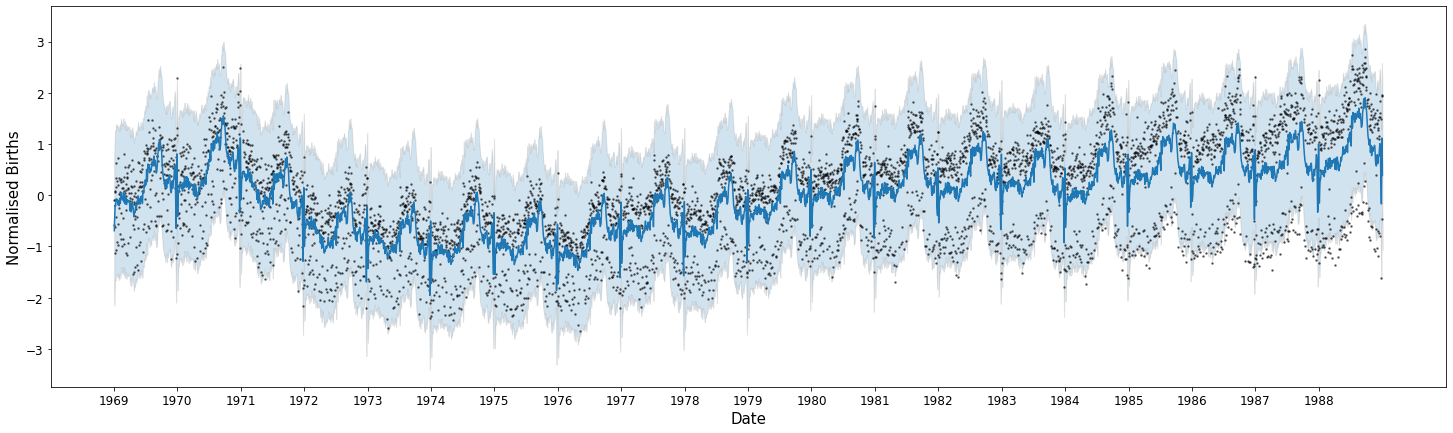

Test


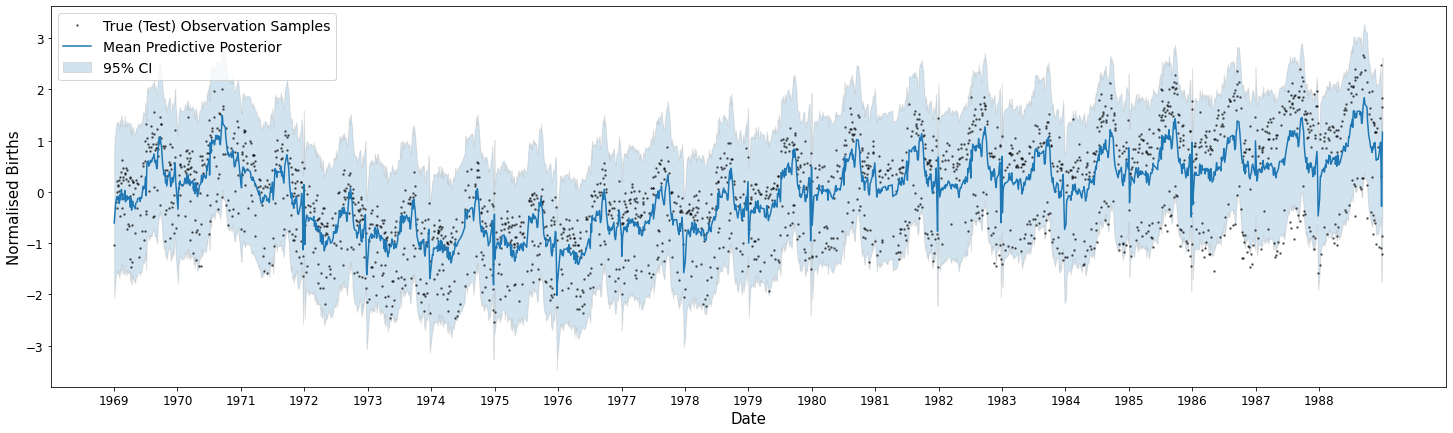

train ELBO, MSE, MAE:  0.5134429314704428 0.6043546134337627
test ELBO, MSE, MAE:  0.5592170129060796 0.6292227564437427
percentage out of CI (train, test):  3.3444161940152553 4.060218978102189
Avg. CRPS (train, test):  0.41006407385118404 0.4283517099983594


---------------------------------------
Train


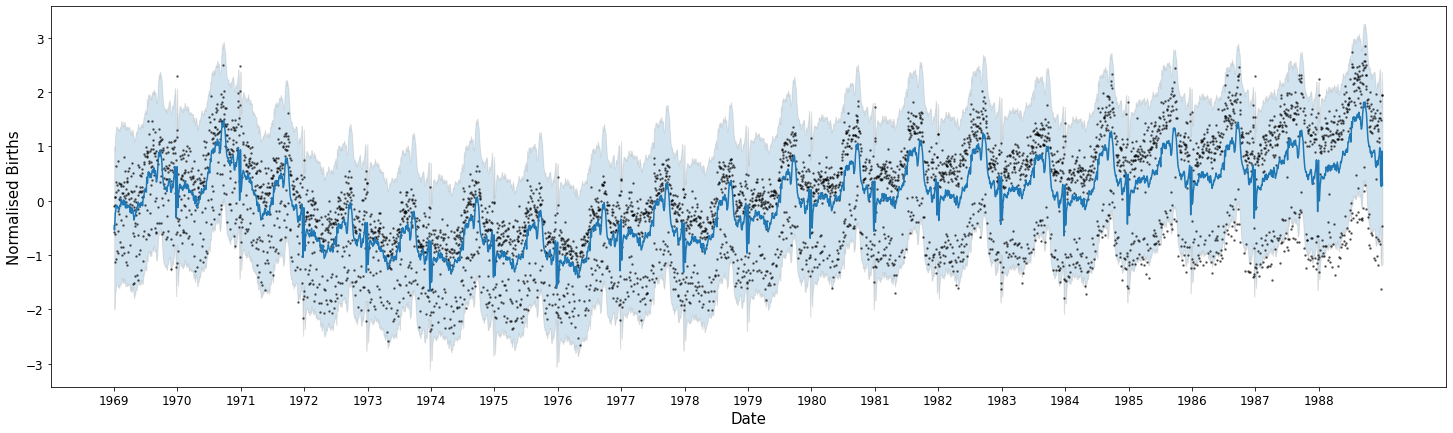

Test


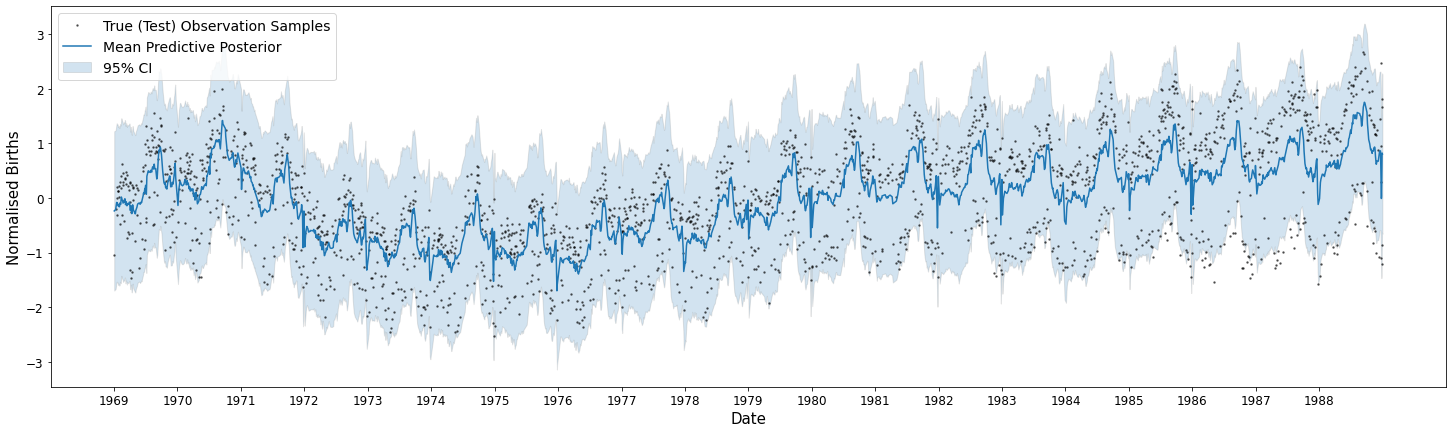

train ELBO, MSE, MAE:  0.5200719206849852 0.609736706739164
test ELBO, MSE, MAE:  0.5641954533110312 0.6335742920991763
percentage out of CI (train, test):  3.4226481517699985 3.695255474452555
Avg. CRPS (train, test):  0.4131517298832222 0.43099682712867154


---------------------------------------


In [7]:
for l2 in [1, 2]:
    kernel = gpflow.kernels.RBF(lengthscales=77, variance=1) + gpflow.kernels.Periodic(gpflow.kernels.Matern32(lengthscales=l2), period=365)
    model = gpflow.models.GPR(data=(x_train, y_train), kernel=kernel, mean_function=None)

    optimise_predict_model(model)
    print('---------------------------------------')